In [1]:
import os
print(os.getcwd())
path_parent = os.path.dirname(os.getcwd())
os.chdir(path_parent)
print(os.getcwd())

C:\Users\danie\Documents\COGS402\cogs402longformer\src
C:\Users\danie\Documents\COGS402\cogs402longformer


In [23]:
#import huggingface models
from transformers import LongformerForSequenceClassification, LongformerTokenizer

tokenizer = LongformerTokenizer.from_pretrained("allenai/longformer-base-4096")

#base model for training 
model = LongformerForSequenceClassification.from_pretrained("allenai/longformer-base-4096",num_labels=2)

#importing local checkpoint
model2 = LongformerForSequenceClassification.from_pretrained("models/longformer-finetuned_papers/checkpoint-2356",num_labels=2)

#import same version from hub
model3 = LongformerForSequenceClassification.from_pretrained("danielhou13/longformer-finetuned_papers",num_labels=2)

In [4]:
import pandas as pd
second_ds = pd.read_csv("data/longdoc.csv")

In [5]:
#split data
#note: can convert to huggingface dataset format first and then use 
#train_test_split
from sklearn.model_selection import train_test_split
train_ds, test_ds = train_test_split(second_ds, test_size=0.2, shuffle=True, random_state=42)

In [6]:
#convert to huggingface dataset
import datasets
train_dataset = datasets.Dataset.from_pandas(train_ds)
val_dataset = datasets.Dataset.from_pandas(test_ds)

In [7]:
#trainer API auto uses dynamic padding... supposedly
def tokenize(examples):
    return tokenizer(examples["text"], truncation=True)

In [8]:
#tokenize the data
train_dataset = train_dataset.map(tokenize, load_from_cache_file=False)
val_dataset = val_dataset.map(tokenize, load_from_cache_file=False)

0ex [00:00, ?ex/s]

0ex [00:00, ?ex/s]

In [9]:
#convert required columns and remove unrequired ones
train_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])
val_dataset.set_format("torch", columns=['input_ids', 'attention_mask', "labels"])

train_dataset = train_dataset.remove_columns(['text', '__index_level_0__'])
val_dataset = val_dataset.remove_columns(['text', '__index_level_0__'])

In [10]:
print(val_dataset)

Dataset({
    features: ['labels', 'input_ids', 'attention_mask'],
    num_rows: 1179
})


In [18]:
#create a local models folder for checkpoint storage
if not os.path.exists("models"):
    os.mkdir("models")

In [11]:
from transformers import Trainer, TrainingArguments

batch_size = 1
gradient_acc = 4
logging_steps = (len(train_dataset) // batch_size) //gradient_acc
model_name = f"longformer-finetuned_papers"
training_args = TrainingArguments(output_dir=f"models/{model_name}",
                                  num_train_epochs = 2,
                                  learning_rate=2e-5,
                                  per_device_train_batch_size=batch_size,
                                  per_device_eval_batch_size=batch_size,
                                  weight_decay=0.01,
                                  evaluation_strategy="epoch",
                                  disable_tqdm=False,
                                  push_to_hub=False,
                                  logging_steps=logging_steps,
                                  log_level="error",
                                  fp16=True,
                                  gradient_accumulation_steps=gradient_acc,
                                  gradient_checkpointing=True,
                                  save_strategy = "epoch")

In [14]:
from transformers import DataCollatorWithPadding
data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [24]:
import torch

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
model2.to(device)
device

device(type='cuda')

In [25]:
from sklearn.metrics import accuracy_score, f1_score

def compute_metrics(pred):
    labels = pred.label_ids
    preds = pred.predictions.argmax(-1)
    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    return {"accuracy": acc, "f1": f1}

In [26]:
trainer = Trainer(
    model=model2,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=val_dataset,
    compute_metrics=compute_metrics,
    tokenizer=tokenizer,
    data_collator = data_collator
)

In [23]:
trainer.train()

Epoch,Training Loss,Validation Loss,Accuracy,F1
0,0.282100,0.328098,0.928753,0.928716
1,0.247200,0.297406,0.927905,0.927840


TrainOutput(global_step=2356, training_loss=0.26465356694012626, metrics={'train_runtime': 8676.142, 'train_samples_per_second': 1.087, 'train_steps_per_second': 0.272, 'total_flos': 2.483085435186846e+16, 'train_loss': 0.26465356694012626, 'epoch': 2.0})

In [27]:
preds_output = trainer.predict(val_dataset)

In [28]:
preds_output.metrics

{'test_loss': 0.2974056303501129,
 'test_accuracy': 0.9279050042408821,
 'test_f1': 0.9278396350594486,
 'test_runtime': 219.4856,
 'test_samples_per_second': 5.372,
 'test_steps_per_second': 5.372}

In [29]:
import numpy as np
y_preds = np.argmax(preds_output.predictions, axis=1)
y_true = np.array(val_dataset["labels"])

In [30]:
from sklearn.metrics import classification_report
print(
    classification_report(
        y_true, y_preds, target_names=["PL", "AI"]
    )
)

              precision    recall  f1-score   support

          PL       0.88      0.98      0.93       568
          AI       0.98      0.88      0.93       611

    accuracy                           0.93      1179
   macro avg       0.93      0.93      0.93      1179
weighted avg       0.93      0.93      0.93      1179



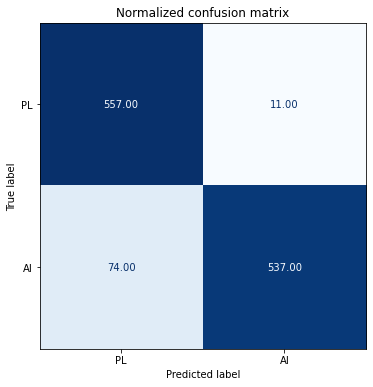

(1179,)
(1179,)


In [31]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
import matplotlib.pyplot as plt

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds)
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["PL", "AI"])
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()

plot_confusion_matrix(y_preds, y_true, labels=[0,1])
print(y_true.shape)
print(y_preds.shape)

In [32]:
# from huggingface_hub import notebook_login

# notebook_login()

In [ ]:
# # upload model to huggingface for storage
# model3.push_to_hub("longformer-finetuned_papers)

In [40]:
# upload the dataset to huggingface for storage
# from datasets import concatenate_datasets
# cogs402dataset = concatenate_datasets([train_dataset, val_dataset])
# cogs402 = cogs402dataset.train_test_split(test_size=0.20)
# print(cogs402)

DatasetDict({
    train: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 4715
    })
    test: Dataset({
        features: ['labels', 'input_ids', 'attention_mask'],
        num_rows: 1179
    })
})


In [41]:
# cogs402.push_to_hub("danielhou13/cogs402dataset")

Pushing split train to the Hub.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]

Pushing split test to the Hub.
The repository already exists: the `private` keyword argument will be ignored.


Pushing dataset shards to the dataset hub:   0%|          | 0/1 [00:00<?, ?it/s]